### Import

In [1]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D, Conv1D
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import os
import KDT

### FinanceDataReader

In [8]:
df = 'AXP' # 아메리칸 익스프레스 주가
df = fdr.DataReader(df)
df.info()
df.head()

c:\Program Files\Python38\lib\site-packages\FinanceDataReader\data.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(more)
c:\Program Files\Python38\lib\site-packages\FinanceDataReader\data.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(more)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10636 entries, 1980-03-18 to 2022-05-23
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   10636 non-null  float64
 1   Open    10636 non-null  float64
 2   High    10636 non-null  float64
 3   Low     10636 non-null  float64
 4   Volume  10636 non-null  float64
 5   Change  10636 non-null  float64
dtypes: float64(6)
memory usage: 581.7 KB


,Close,Open,High,Low,Volume,Change
Date,,,,,,
1980-03-18,1.92,1.92,1.92,1.85,3080000.0,0.0267
1980-03-19,1.92,1.92,1.94,1.90,744010.0,0.0000
1980-03-20,1.88,1.88,1.91,1.87,856800.0,-0.0208
1980-03-21,1.89,1.89,1.90,1.86,986400.0,0.0053
1980-03-24,1.87,1.87,1.89,1.86,1560000.0,-0.0106


Text(0, 0.5, 'price')

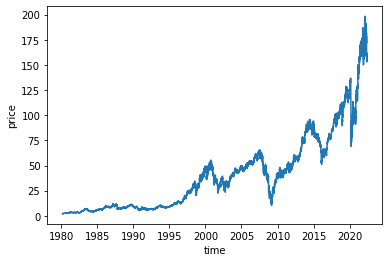

In [9]:
# 표
sns.lineplot(y=df['Close'], x=df.index)
plt.xlabel('time')
plt.ylabel('price')

### 데이터 전처리

In [10]:
KDT.MID(df)  # 중위값
KDT.GC_DC(df, 20, 200)  # 이동평균선 & golden cross death cross
KDT.Bollinger(df)  # Bollinger Bands
KDT.RSI(df)  # RSI


In [16]:
df.head(30)

,Close,Open,High,Low,Volume,Change,Mid,MA20,MA200,stddev,upper,lower,RSI
Date,,,,,,,,,,,,,
1980-03-18,1.92,1.92,1.92,1.85,3080000.0,0.0267,1.885,NaN,NaN,NaN,NaN,NaN,NaN
1980-03-19,1.92,1.92,1.94,1.90,744010.0,0.0000,1.920,NaN,NaN,NaN,NaN,NaN,NaN
1980-03-20,1.88,1.88,1.91,1.87,856800.0,-0.0208,1.890,NaN,NaN,NaN,NaN,NaN,NaN
1980-03-21,1.89,1.89,1.90,1.86,986400.0,0.0053,1.880,NaN,NaN,NaN,NaN,NaN,NaN
1980-03-24,1.87,1.87,1.89,1.86,1560000.0,-0.0106,1.875,NaN,NaN,NaN,NaN,NaN,NaN
1980-03-25,1.89,1.89,1.90,1.86,213600.0,0.0107,1.880,NaN,NaN,NaN,NaN,NaN,NaN
1980-03-26,1.95,1.95,1.96,1.90,715210.0,0.0317,1.930,NaN,NaN,NaN,NaN,NaN,NaN
1980-03-27,2.05,2.05,2.05,1.91,922800.0,0.0513,1.980,NaN,NaN,NaN,NaN,NaN,NaN
1980-03-28,2.09,2.09,2.10,2.02,948000.0,0.0195,2.060,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df.tail(30)
write_csv(df, 'df.csv' )

,Close,Open,High,Low,Volume,Change,Mid,MA20,MA200,stddev,upper,lower,RSI
Date,,,,,,,,,,,,,
2022-04-11,177.57,181.06,182.44,177.25,4780000.0,-0.0334,179.845,186.2475,172.96340,4.396306,195.040111,177.454889,40.892247
2022-04-12,175.54,176.57,179.25,174.71,4330000.0,-0.0114,176.980,186.2225,173.01720,4.458390,195.139280,177.305720,38.662185
2022-04-13,179.59,174.23,180.02,174.00,2970000.0,0.0231,177.010,186.1715,173.09390,4.531210,195.233920,177.109080,45.095403
2022-04-14,181.16,179.27,182.47,178.68,2670000.0,0.0087,180.575,185.8810,173.17355,4.661687,195.204374,176.557626,47.398577
2022-04-18,184.48,181.33,185.89,181.00,2180000.0,0.0183,183.445,185.5690,173.26125,4.527665,194.624329,176.513671,51.985424
2022-04-19,187.17,185.01,188.09,184.71,2560000.0,0.0146,186.400,185.4730,173.35460,4.469055,194.411110,176.534890,55.380433
2022-04-20,188.46,188.33,190.15,187.64,2250000.0,0.0069,188.895,185.3295,173.44910,4.314495,193.958490,176.700510,56.952385
2022-04-21,185.74,190.94,192.42,184.58,3750000.0,-0.0144,188.500,185.3155,173.52290,4.312590,193.940681,176.690319,52.733801
2022-04-22,180.54,185.43,185.55,180.32,4370000.0,-0.0280,182.935,184.8980,173.58810,4.352329,193.602657,176.193343,45.755952


In [17]:
# %% 데이터 스케일링 min max scaler
scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume',
              'MA20', 'MA200', 'stddev', 'upper', 'lower', 'RSI', 'Mid']
scaled = scaler.fit_transform(df[scale_cols])
df = pd.DataFrame(scaled, columns=scale_cols)

# train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)
KDT.train_test_split_print(x_train, x_test, y_train, y_test)

x_train shape :  (8349, 11)
y_train shape :  (8349,)
x_test shape :  (2088, 11)
y_test shape :  (2088,)


C:\Users\yzz07\AppData\Local\Temp\ipykernel_2328\1941254144.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)


In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1) # 차원 늘리기
    ds = tf.data.Dataset.from_tensor_slices(series)  
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

WINDOW_SIZE = 10
BATCH_SIZE = 32

In [19]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')


데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 10, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [20]:
model = Sequential([
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [21]:
loss = Huber()
optimizer = Adam(0.0003)
model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])
earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(
    filename, save_weights_only=True, save_best_only=True, monitor='val_loss', verbose=1)

history = model.fit(train_data, validation_data=(test_data),
                    epochs=100, callbacks=[checkpoint, earlystopping])

Epoch 1/100
    257/Unknown - 3s 5ms/step - loss: 3.3654e-05 - mse: 6.7308e-05
Epoch 1: val_loss improved from inf to 0.00074, saving model to tmp\ckeckpointer.ckpt
261/261 [==============================] - 4s 8ms/step - loss: 3.3716e-05 - mse: 6.7432e-05 - val_loss: 7.3524e-04 - val_mse: 0.0015
Epoch 2/100
255/261 [============================>.] - ETA: 0s - loss: 1.6327e-05 - mse: 3.2655e-05
Epoch 2: val_loss improved from 0.00074 to 0.00072, saving model to tmp\ckeckpointer.ckpt
261/261 [==============================] - 2s 6ms/step - loss: 1.6765e-05 - mse: 3.3530e-05 - val_loss: 7.1554e-04 - val_mse: 0.0014
Epoch 3/100
258/261 [============================>.] - ETA: 0s - loss: 1.6949e-05 - mse: 3.3898e-05
Epoch 3: val_loss did not improve from 0.00072
261/261 [==============================] - 1s 5ms/step - loss: 1.7100e-05 - mse: 3.4199e-05 - val_loss: 7.2291e-04 - val_mse: 0.0014
Epoch 4/100
258/261 [============================>.] - ETA: 0s - loss: 1.4503e-05 - mse: 2.9005e-05

In [22]:
model.load_weights(filename)
pred = model.predict(test_data)
pred.shape

(2078, 1)

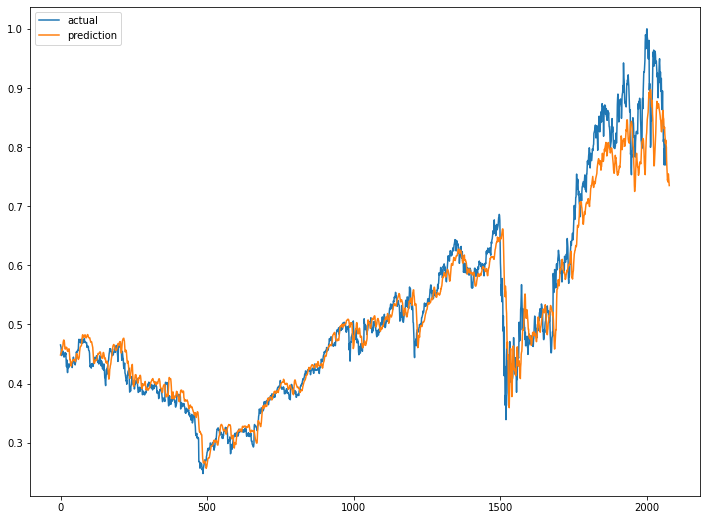

In [23]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

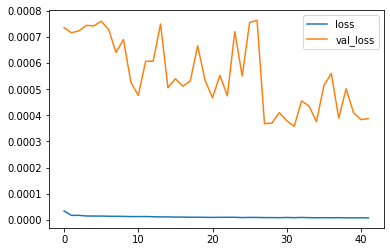

In [24]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()